# Imports

In [3]:
# jupyter extensions
%load_ext autoreload
%autoreload 2
%matplotlib inline

# imports
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as clr
from pyproj import Proj, transform
from pandas_plink import read_plink
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import networkx as nx
import yaml
import sys
import json
from copy import deepcopy

# feems modules
sys.path.append("../scripts/feems_vw/")
from graph import Graph
from sumstat import SummaryStatistics
from objective import Objective, neg_log_lik_wrapper, loss_wrapper
from feems_opt import FEEMS
from viz import plot_graph
from viz2 import Viz
from utils import prepare_input, setup_kfold_cv, recover_nnz_entries, create_feems_train_val

# matplotlib plot style
plt.style.use('../data/whitegrid.mplstyle')
plt.rcParams['text.usetex'] = False
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Functions

In [4]:
def draw_admix_pie(admix_fracs, 
                   x, y, 
                   colors,
                   radius=.18, 
                   inset_width=.5,
                   inset_height=.5,
                   loc=10,
                   linewidth=.2,
                   edgecolor="black",
                   ax=None):
    """Draws a single admixture pie on a axis
    """
    xy = (x, y)
    ax_i = inset_axes(ax, 
                      width=inset_width, 
                      height=inset_height, 
                      loc=loc, 
                      bbox_to_anchor=(x, y),
                      bbox_transform=ax.transData, 
                      borderpad=0)
    wedges, t = ax_i.pie(admix_fracs, 
                         colors=colors, 
                         center=xy, 
                         radius=radius, 
                         wedgeprops={"linewidth": linewidth, 
                                     "edgecolor": edgecolor})

# Data

In [5]:
%%time
# input file paths
prefix = "../data/preprocessed/wolvesadmix/wolvesadmix"
coord_path = "{}.coord".format(prefix)
outer_path = "{}.outer".format(prefix)

# read the genotype data and mean impute missing data
(bim, fam, G) = read_plink(prefix)
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)

# read the eems input files
n, p = genotypes.shape
coord = np.loadtxt(coord_path)
outer = np.loadtxt(outer_path)
outer, edges, grid, ipmap = prepare_input(coord=coord, 
                                          ggrid="../data/grids/grid_200.shp",
                                          translated=True,
                                          buffer=0,
                                          outer=outer)

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 36.31it/s]


CPU times: user 2.2 s, sys: 153 ms, total: 2.35 s
Wall time: 3.03 s


Dummy fit for creating the map:

In [6]:
%%time
feems = FEEMS(genotypes, coord, grid, edges)
lamb = .001
alpha = 50
feems.fit_w0_s2() 
feems.fit_quasi_newton(lamb_l2=0.0, lamb_smth=lamb, lamb_log=alpha, w_init=feems.graph.w0, factr=1e9)

constant-w/variance fit, converged in 131 iterations, train_loss=-176724.3936252
lambda_l2=0.0000000, lambda=0.0010000, alpha=50.0000000, converged in 57 iterations, train_loss=-213376.1850985
CPU times: user 7.59 s, sys: 0 ns, total: 7.59 s
Wall time: 7.6 s


# Visualization

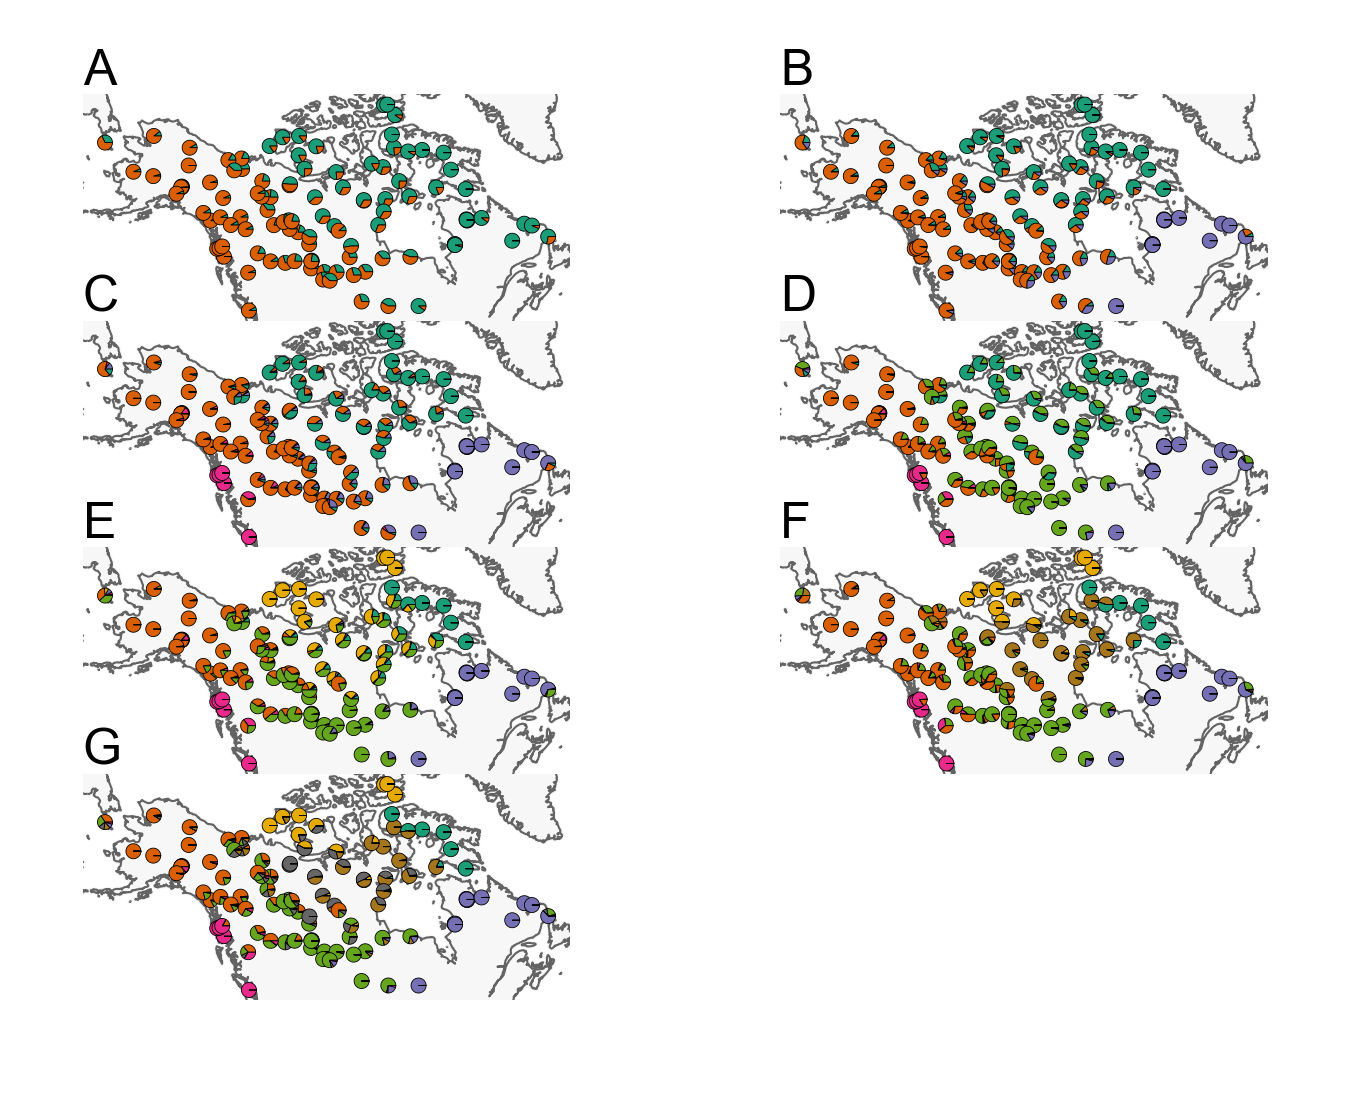

In [12]:
#################### figure params ####################
title_pad = -10
title_loc = "left"
dpi = 300
radius = .125
projection = ccrs.EquidistantConic(central_longitude=-108.842926, central_latitude=66.037547)

#################### highest lik replicates ####################
r_k2 = np.argmax(np.array([-2030165.623325, -2029835.957431, -2030165.623274, -2030165.623277, -2030656.057984]))
r_k3 = np.argmax(np.array([-1984364.658880, -1984364.652158, -1984364.653400, -1984364.652532, -1984364.651665]))
r_k4 = np.argmax(np.array([-1955782.366716, -1955498.244366, -1955498.213598, -1955498.213456, -1955498.213969]))
r_k5 = np.argmax(np.array([-1926926.791028, -1926926.777753, -1933292.950473, -1926926.775788, -1926926.800353]))
r_k6 = np.argmax(np.array([-1904741.349810, -1904741.346244, -1904734.519948, -1904734.527477, -1904734.553378]))
r_k7 = np.argmax(np.array([-1886211.959680, -1886204.854163, -1886204.885589, -1886204.843782, -1886204.853145]))
r_k8 = np.argmax(np.array([-1871956.916639, -1873643.000452, -1869685.178571, -1872112.115730]))

#################### admixture fractions ####################
Q_k2 = np.loadtxt("../output/admixture/wolvesadmix/wolvesadmix.K2r{}.Q".format(r_k2))
Q_k3 = np.loadtxt("../output/admixture/wolvesadmix/wolvesadmix.K3r{}.Q".format(r_k3))
Q_k4 = np.loadtxt("../output/admixture/wolvesadmix/wolvesadmix.K4r{}.Q".format(r_k4))
Q_k5 = np.loadtxt("../output/admixture/wolvesadmix/wolvesadmix.K5r{}.Q".format(r_k5))
Q_k6 = np.loadtxt("../output/admixture/wolvesadmix/wolvesadmix.K6r{}.Q".format(r_k6))
Q_k7 = np.loadtxt("../output/admixture/wolvesadmix/wolvesadmix.K7r{}.Q".format(r_k7))
Q_k8 = np.loadtxt("../output/admixture/wolvesadmix/wolvesadmix.K8r{}.Q".format(r_k8))

#################### colors ####################
colors_k2 = ["#1b9e77", "#d95f02"] # x
colors_k3 = ["#1b9e77", "#d95f02", "#7570b3"] # x
colors_k4 = ["#7570b3", "#e7298a", "#d95f02", "#1b9e77"] # x
colors_k5 = ["#e7298a", "#66a61e", "#d95f02", "#1b9e77", "#7570b3"] # x 
colors_k6 = ["#1b9e77", "#e7298a", "#7570b3", "#e6ab02", "#d95f02", "#66a61e"] # x
colors_k7 = ["#e6ab02", "#a6761d", "#66a61e", "#7570b3", "#e7298a", "#1b9e77", "#d95f02"] # x 
colors_k8 = ["#1b9e77", "#e6ab02", "#d95f02", "#66a61e", "#666666", "#a6761d", "#7570b3", "#e7298a"] # x

#################### figure setup ####################
fig = plt.figure(dpi=dpi)
spec = gridspec.GridSpec(ncols=2, nrows=4, figure=fig, wspace=0.0, hspace=0.0)

#################### axis 00 ####################
ax_00 = fig.add_subplot(spec[0, 0], projection=projection)
ax_00.set_title("A", loc=title_loc, pad=title_pad)
v = Viz(ax_00, feems, projection=projection)
v.draw_map()
ax_00.scatter(v.coord[:,0], v.coord[:,1], marker=".", s=0.0)
for i in range(n):
    draw_admix_pie(Q_k2[i, :], 
                   v.coord[i, 0], 
                   v.coord[i, 1], 
                   colors_k2, 
                   radius=radius,
                   ax=ax_00)
    
#################### axis 01 ####################
ax_01 = fig.add_subplot(spec[0, 1], projection=projection)
ax_01.set_title("B", loc=title_loc, pad=title_pad)
v = Viz(ax_01, feems, projection=projection)
v.draw_map()
ax_01.scatter(v.coord[:,0], v.coord[:,1], marker=".", s=0)
for i in range(n):
    draw_admix_pie(Q_k3[i, :], 
                   v.coord[i, 0], 
                   v.coord[i, 1], 
                   colors_k3, 
                   radius=radius,
                   ax=ax_01)

#################### axis 10 ####################
ax_10 = fig.add_subplot(spec[1, 0], projection=projection)
ax_10.set_title("C", loc=title_loc, pad=title_pad)
v = Viz(ax_10, feems, projection=projection)
v.draw_map()
ax_10.scatter(v.coord[:,0], v.coord[:,1], marker=".", s=0)
for i in range(n):
    draw_admix_pie(Q_k4[i, :], 
                   v.coord[i, 0], 
                   v.coord[i, 1], 
                   colors_k4, 
                   radius=radius,
                   ax=ax_10)

#################### axis 11 ####################
ax_11 = fig.add_subplot(spec[1, 1], projection=projection)
ax_11.set_title("D", loc=title_loc, pad=title_pad)
v = Viz(ax_11, feems, projection=projection)
v.draw_map()
ax_11.scatter(v.coord[:,0], v.coord[:,1], marker=".", s=0)
for i in range(n):
    draw_admix_pie(Q_k5[i, :], 
                   v.coord[i, 0], 
                   v.coord[i, 1], 
                   colors_k5, 
                   radius=radius,
                   ax=ax_11)

#################### axis 20 ####################
ax_20 = fig.add_subplot(spec[2, 0], projection=projection)
ax_20.set_title("E", loc=title_loc, pad=title_pad)
v = Viz(ax_20, feems, projection=projection)
v.draw_map()
ax_20.scatter(v.coord[:,0], v.coord[:,1], marker=".", s=0)
for i in range(n):
    draw_admix_pie(Q_k6[i, :], 
                   v.coord[i, 0], 
                   v.coord[i, 1], 
                   colors_k6, 
                   radius=radius,
                   ax=ax_20)

#################### axis 21 ####################
ax_21 = fig.add_subplot(spec[2, 1], projection=projection)
ax_21.set_title("F", loc=title_loc, pad=title_pad)
v = Viz(ax_21, feems, projection=projection)
v.draw_map()
ax_21.scatter(v.coord[:,0], v.coord[:,1], marker=".", s=0)
for i in range(n):
    draw_admix_pie(Q_k7[i, :], 
                   v.coord[i, 0], 
                   v.coord[i, 1], 
                   colors_k7, 
                   radius=radius,
                   ax=ax_21)

#################### axis 30 ####################
ax_30 = fig.add_subplot(spec[3, 0], projection=projection)
ax_30.set_title("G", loc=title_loc, pad=title_pad)
v = Viz(ax_30, feems, projection=projection)
v.draw_map()
ax_30.scatter(v.coord[:,0], v.coord[:,1], marker=".", s=0)
for i in range(n):
    draw_admix_pie(Q_k8[i, :], 
                   v.coord[i, 0], 
                   v.coord[i, 1], 
                   colors_k8, 
                   radius=radius,
                   ax=ax_30)
    
fig.savefig(
    "../output/figures/supp-figure-10-admixture.pdf", bbox_inches="tight", pad_inches=0.0
) 

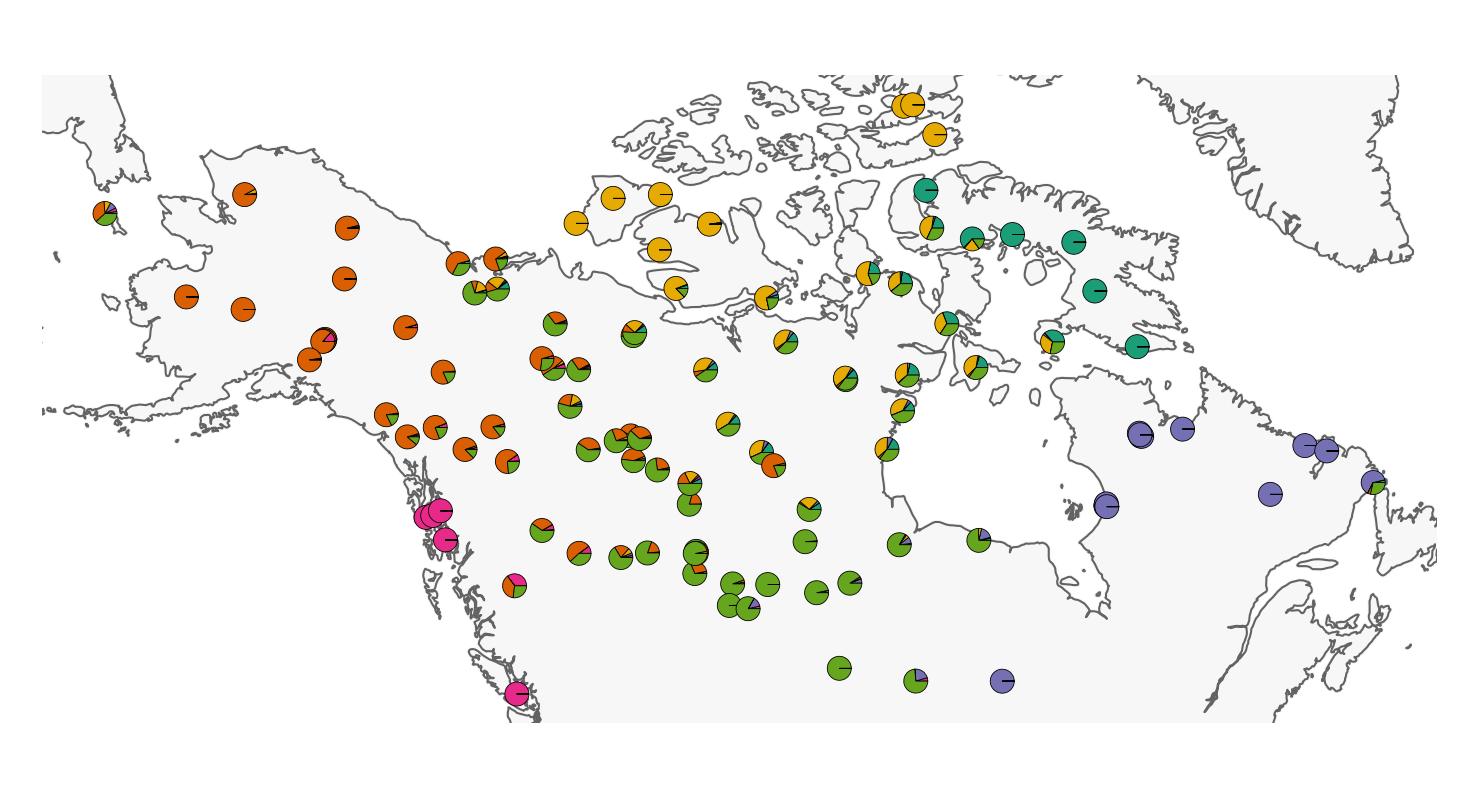

In [13]:
projection = ccrs.EquidistantConic(central_longitude=-108.842926, central_latitude=66.037547)
radius = .2
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  

# setup viz and attributes
v = Viz(ax, feems, projection=projection)
v.draw_map()
ax.scatter(v.coord[:,0], v.coord[:,1], marker=".", s=0)
for i in range(n):
    draw_admix_pie(Q_k6[i, :], 
                   v.coord[i, 0], 
                   v.coord[i, 1], 
                   colors_k6, 
                   radius=radius,
                   ax=ax)